# Imports

In [117]:
import pandas as pd
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns 
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 12,8

In [118]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, KFold

from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, precision_score, recall_score, f1_score 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
# models
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [119]:
import warnings
warnings.filterwarnings('ignore')

# Data Loading & Inspection

In [120]:
# Data Loading
data = pd.read_csv("/Credit-Risk-Assessment/Datasets/german_credit_data.csv")

In [121]:
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [122]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


In [123]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1000.0,499.500,288.819436,0.0,249.75,499.5,749.25,999.0
Age,1000.0,35.546,11.375469,19.0,27.00,33.0,42.00,75.0
Job,1000.0,1.904,0.653614,0.0,2.00,2.0,2.00,3.0
Credit amount,1000.0,3271.258,2822.736876,250.0,1365.50,2319.5,3972.25,18424.0
Duration,1000.0,20.903,12.058814,4.0,12.00,18.0,24.00,72.0


In [124]:
# Number of unique values per column
print(data.nunique())

print("Sex : ",data.Sex.unique())
print("Housing : ",data.Housing.unique())
print("Saving accounts : ",data['Saving accounts'].unique())
print("Checking account : ",data['Checking account'].unique())
print("Purpose : ",data.Purpose.unique())
print("Risk : ",data['Risk'].unique())

Unnamed: 0          1000
Age                   53
Sex                    2
Job                    4
Housing                3
Saving accounts        4
Checking account       3
Credit amount        921
Duration              33
Purpose                8
Risk                   2
dtype: int64
Sex :  ['male' 'female']
Housing :  ['own' 'free' 'rent']
Saving accounts :  [nan 'little' 'quite rich' 'rich' 'moderate']
Checking account :  ['little' 'moderate' nan 'rich']
Purpose :  ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']
Risk :  ['good' 'bad']


# Data Exploration

  labels  class_nums
0   good         700
1    bad         300


<AxesSubplot:ylabel='class_nums'>

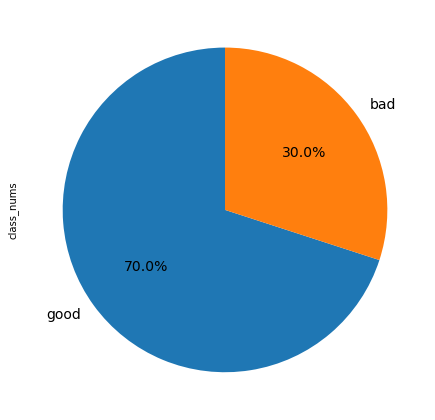

In [125]:
# Check if data is balanced
temp = data['Risk'].value_counts()
temp_data = pd.DataFrame({'labels': temp.index,
                   'class_nums': temp.values
                  })
print(temp_data)
plt.figure(figsize=(16,8))
ax1 = plt.subplot(121, aspect='equal')
temp_data.plot(kind='pie', y = 'class_nums', ax=ax1, autopct='%1.1f%%', 
 startangle=90, shadow=False, labels=temp_data['labels'], legend = False, fontsize=14)

## Initial Preprocessing

In [126]:
data.isnull().sum()

Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [127]:
# Handle nulls
data['Saving accounts'] = data['Saving accounts'].fillna(data['Saving accounts'].mode()[0])
data['Checking account'] = data['Checking account'].fillna(data['Checking account'].mode()[0])

In [128]:
# make sure that nulls are handled
data.isnull().sum()

Unnamed: 0          0
Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64

In [129]:
data.duplicated().sum()

0

In [130]:
data.drop_duplicates(inplace=True)

In [131]:
def find_outliers(data):
    outliers_cols = []
    for col in data.columns:
        if data[col].dtype != 'object':
            q1 = data[col].quantile(0.25)
            q3 = data[col].quantile(0.75)
            iqr = q3 - q1
            
            if len(data[(data[col] < q1 - 1.5 * iqr) | (data[col] > q3 + 1.5 * iqr)]) > 0:
                outliers_cols.append(col)
    return outliers_cols

outliers_cols = find_outliers(data)
print(outliers_cols)

['Age', 'Job', 'Credit amount', 'Duration']


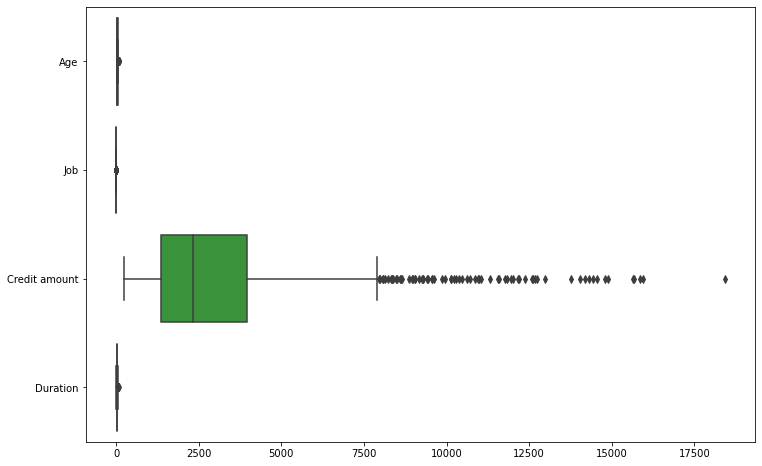

In [132]:
# Outliers Box-plot
temp_data = data[outliers_cols].copy()
ax = sns.boxplot(data=temp_data, orient="h")

In [133]:
data.rename(columns={'Risk': 'target'}, inplace=True)
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,target
0,0,67,male,2,own,little,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,little,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


## Categorical Features

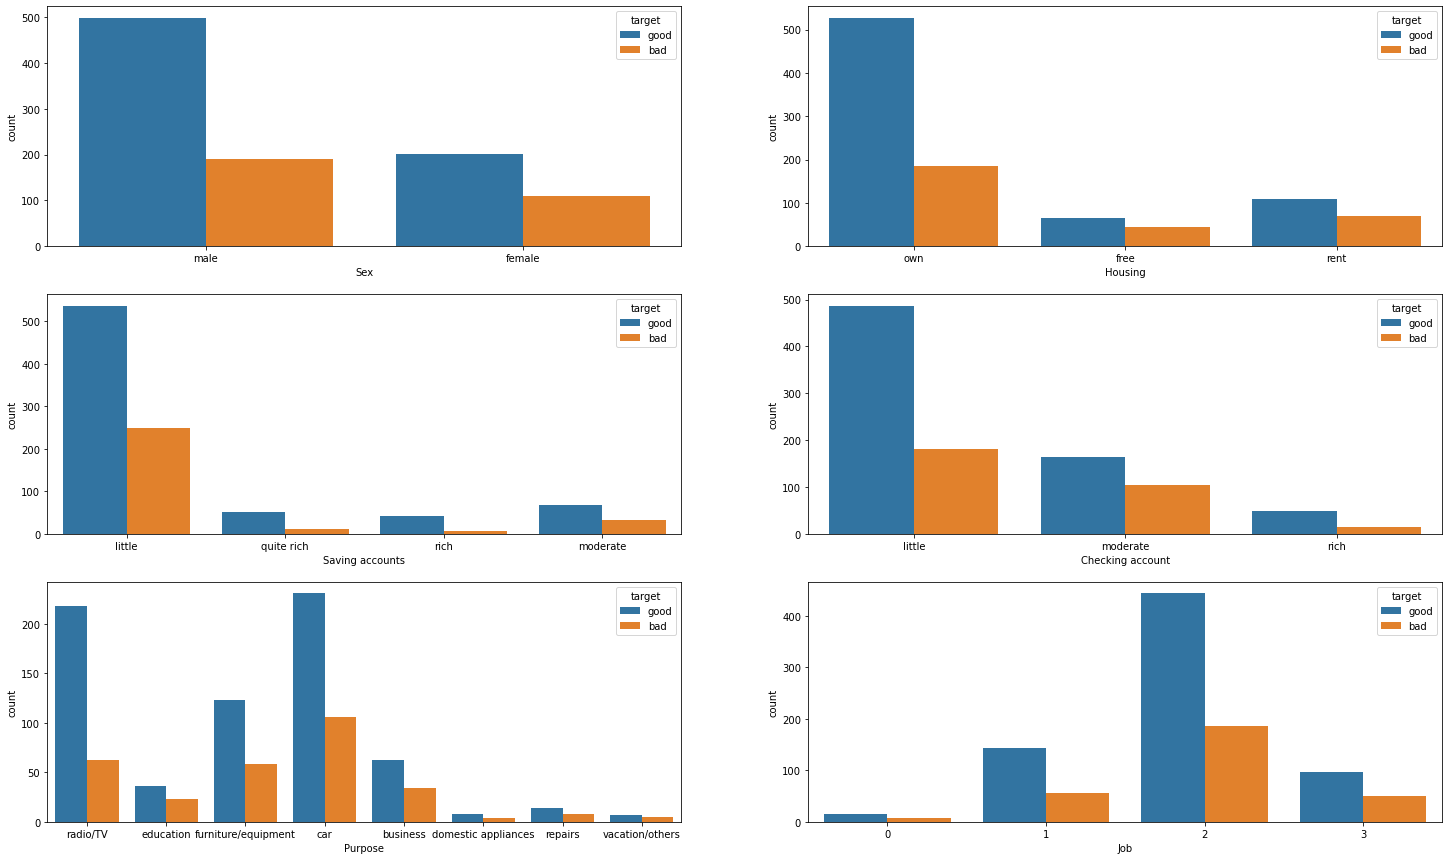

In [134]:
fig, ax =plt.subplots(3,2, figsize = (25,15))
sns.countplot(data['Sex'], hue = data['target'], ax=ax[0,0])
sns.countplot(data['Housing'], hue = data['target'], ax=ax[0,1])
sns.countplot(data['Saving accounts'], hue = data['target'], ax=ax[1,0])
sns.countplot(data['Checking account'], hue = data['target'], ax=ax[1,1])
sns.countplot(data['Purpose'], hue = data['target'], ax=ax[2,0])
sns.countplot(data['Job'], hue = data['target'], ax=ax[2,1])
fig.show()

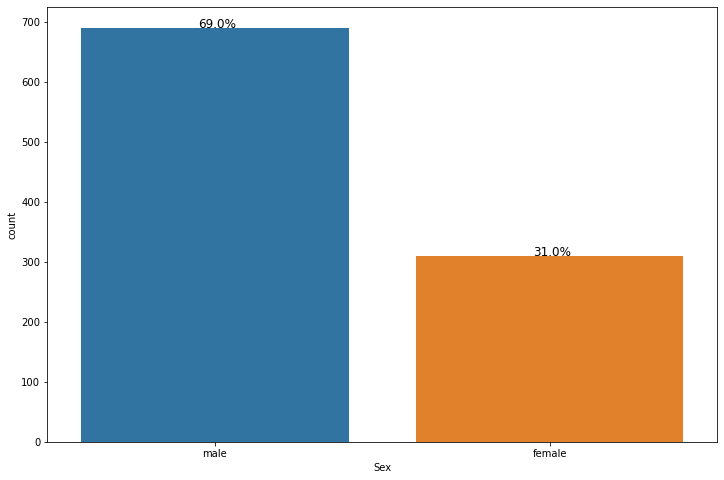

In [135]:
ax = sns.countplot(data['Sex'])
total = len(data['Sex'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), size = 12)

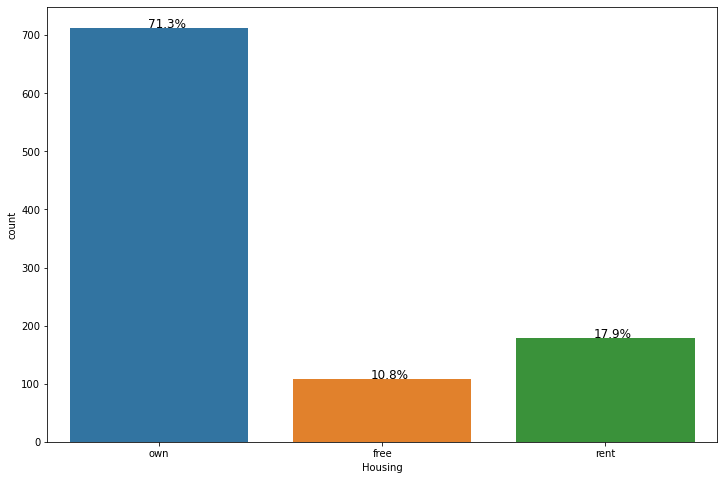

In [136]:
ax = sns.countplot(data['Housing'])
total = len(data['Housing'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), size = 12)

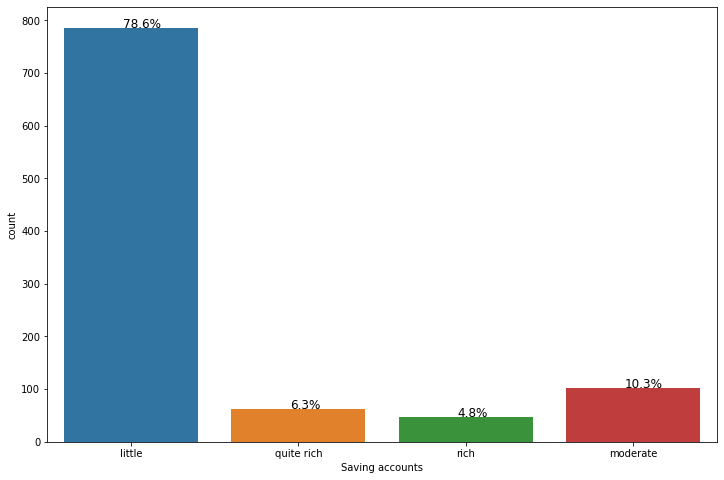

In [137]:
ax = sns.countplot(data['Saving accounts'])
total = len(data['Saving accounts'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), size = 12)

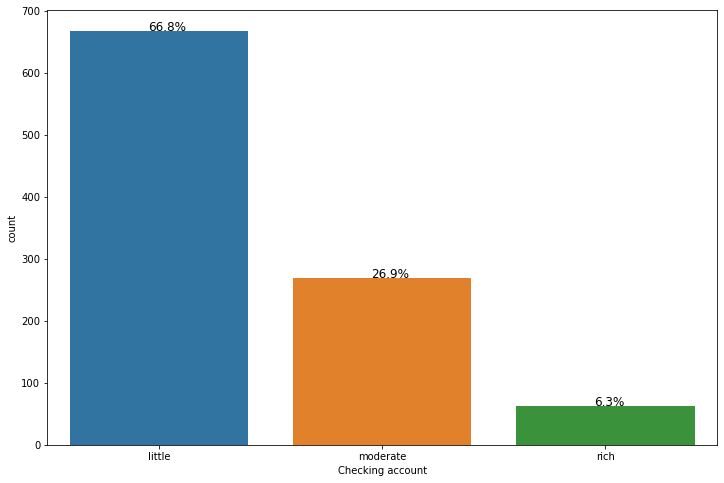

In [138]:
ax = sns.countplot(data['Checking account'])
total = len(data['Checking account'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), size = 12)

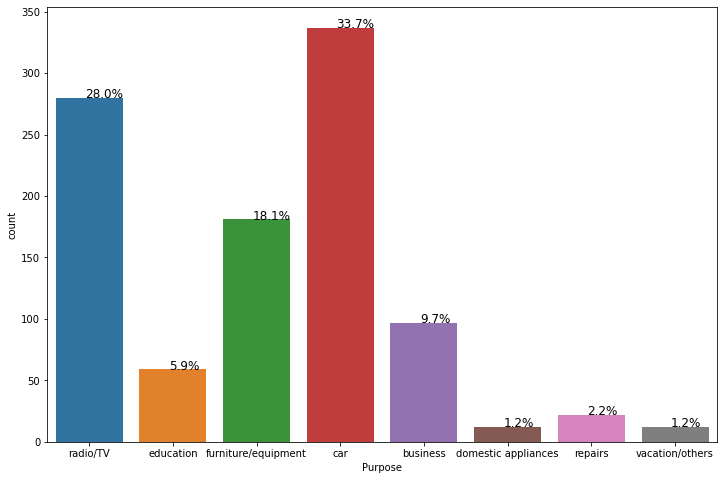

In [139]:
ax = sns.countplot(data['Purpose'])
total = len(data['Purpose'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), size = 12)

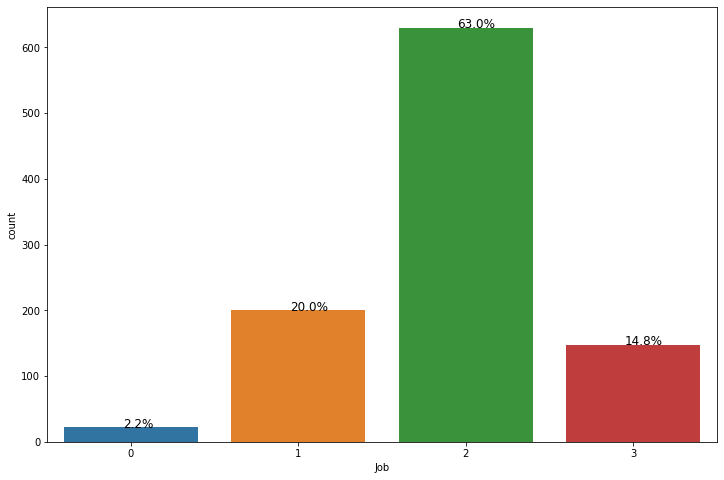

In [140]:
ax = sns.countplot(data['Job'])
total = len(data['Job'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), size = 12)

## Non-Categorical Features

### Age

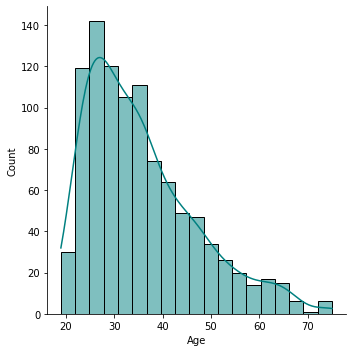

In [141]:
sns.displot(data = data, x = 'Age', kde = True, color = 'teal')

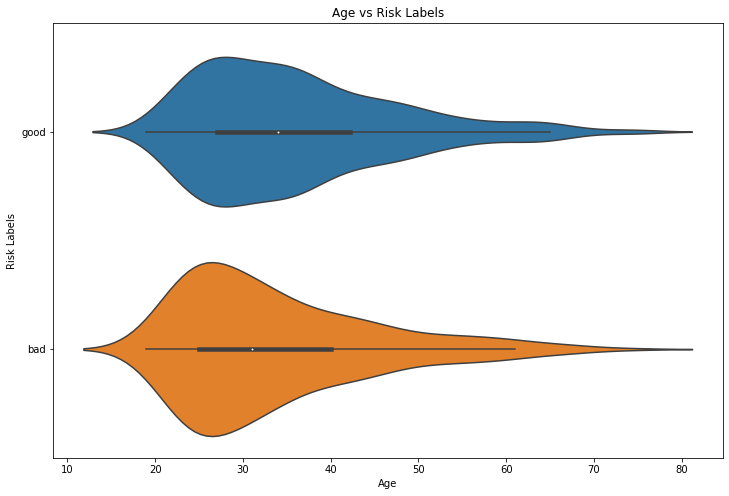

In [142]:
sns.violinplot( x=data["Age"], y=data["target"])
plt.title('Age vs Risk Labels')
plt.ylabel('Risk Labels')
plt.xlabel('Age')
plt.show()

Text(0.5, 0, 'Count')

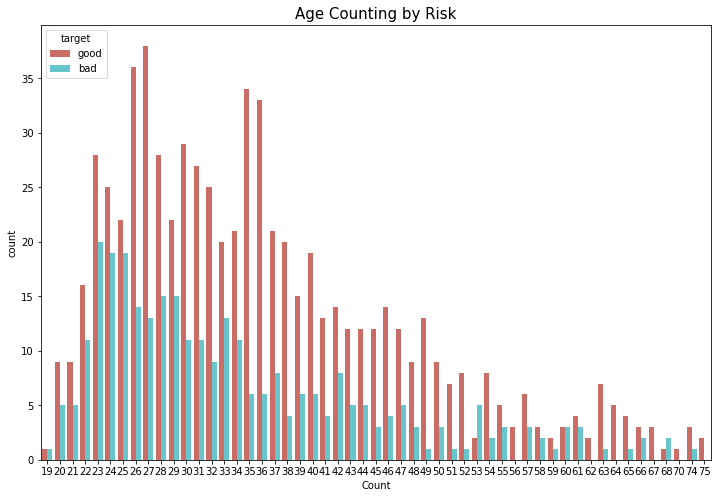

In [143]:
ax = sns.countplot(x="Age",data=data, 
              palette="hls", 
              hue = "target")
ax.set_title("Age Counting by Risk", fontsize=15)
ax.set_xlabel("Age")
ax.set_xlabel("Count")

### Credit Amount

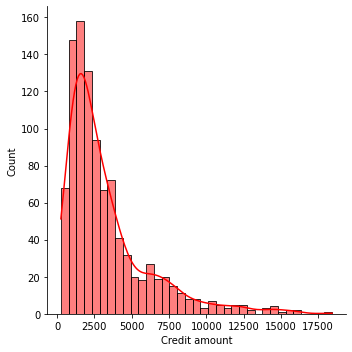

In [144]:
sns.displot(data = data, x = 'Credit amount', kde = True, color = 'red')

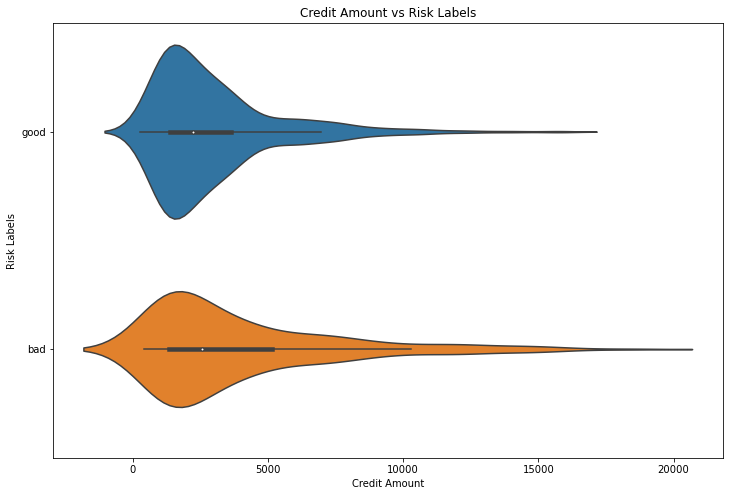

In [145]:
sns.violinplot( x=data["Credit amount"], y=data["target"])
plt.title('Credit Amount vs Risk Labels')
plt.ylabel('Risk Labels')
plt.xlabel('Credit Amount')
plt.show()

### Duration

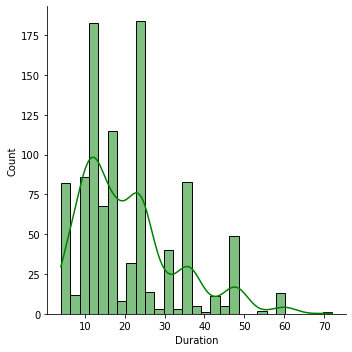

In [146]:
sns.displot(data = data, x = 'Duration', kde = True, color = 'green')

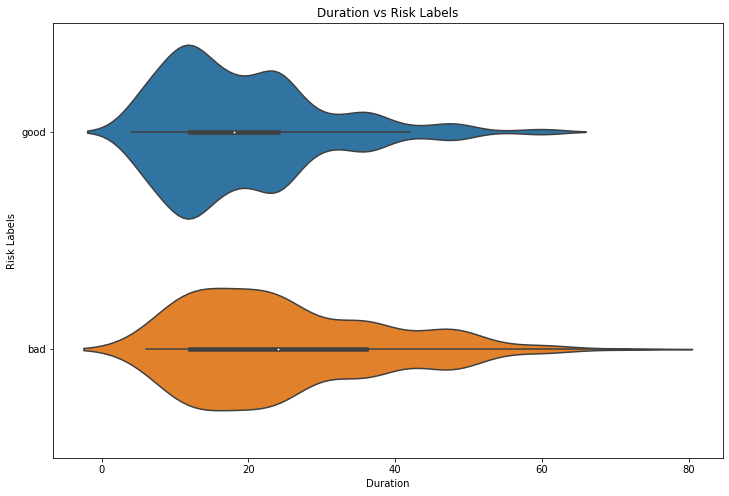

In [147]:
sns.violinplot( x=data["Duration"], y=data["target"])
plt.title('Duration vs Risk Labels')
plt.ylabel('Risk Labels')
plt.xlabel('Duration')
plt.show()

Text(0.5, 0, 'Count')

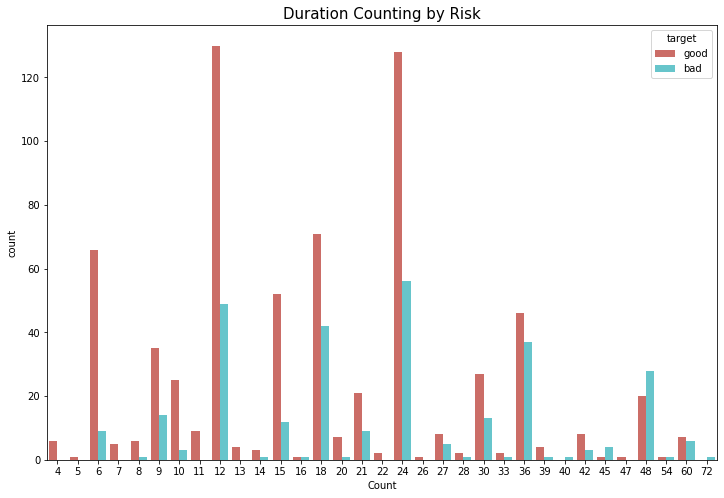

In [148]:
ax = sns.countplot(x="Duration",data=data, 
              palette="hls", 
              hue = "target")
ax.set_title("Duration Counting by Risk", fontsize=15)
ax.set_xlabel("Duration")
ax.set_xlabel("Count")

# Data Preprocessing

In [149]:
# map each category of the target to a number
di = {"bad": 0, "good": 1}
data['target'].replace(di, inplace=True)
data['target'] = data['target'].to_frame()
print(data['target'])

0      1
1      0
2      1
3      1
4      0
      ..
995    1
996    1
997    1
998    0
999    1
Name: target, Length: 1000, dtype: int64


In [150]:
data = pd.get_dummies(data, columns =['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose'])

In [151]:
data.head()

,Unnamed: 0,Age,Job,Credit amount,Duration,target,Sex_female,Sex_male,Housing_free,Housing_own,...,Checking account_moderate,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,0,67,2,1169,6,1,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
1,1,22,2,5951,48,0,1,0,0,1,...,1,0,0,0,0,0,0,1,0,0
2,2,49,1,2096,12,1,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
3,3,45,2,7882,42,1,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
4,4,53,2,4870,24,0,0,1,1,0,...,0,0,0,1,0,0,0,0,0,0


In [152]:
# After encoding delete some columns beacues they include the same information with their pair
data.drop(['Sex_female'], axis = 1, inplace = True)

In [153]:
data.drop(data.columns[0], axis=1)

,Age,Job,Credit amount,Duration,target,Sex_male,Housing_free,Housing_own,Housing_rent,Saving accounts_little,...,Checking account_moderate,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,67,2,1169,6,1,1,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
1,22,2,5951,48,0,0,0,1,0,1,...,1,0,0,0,0,0,0,1,0,0
2,49,1,2096,12,1,1,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
3,45,2,7882,42,1,1,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,53,2,4870,24,0,1,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,31,1,1736,12,1,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
996,40,3,3857,30,1,1,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
997,38,2,804,12,1,1,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
998,23,2,1845,45,0,1,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [154]:
data.head()

,Unnamed: 0,Age,Job,Credit amount,Duration,target,Sex_male,Housing_free,Housing_own,Housing_rent,...,Checking account_moderate,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,0,67,2,1169,6,1,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,1,22,2,5951,48,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
2,2,49,1,2096,12,1,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,3,45,2,7882,42,1,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,4,53,2,4870,24,0,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0


<AxesSubplot:>

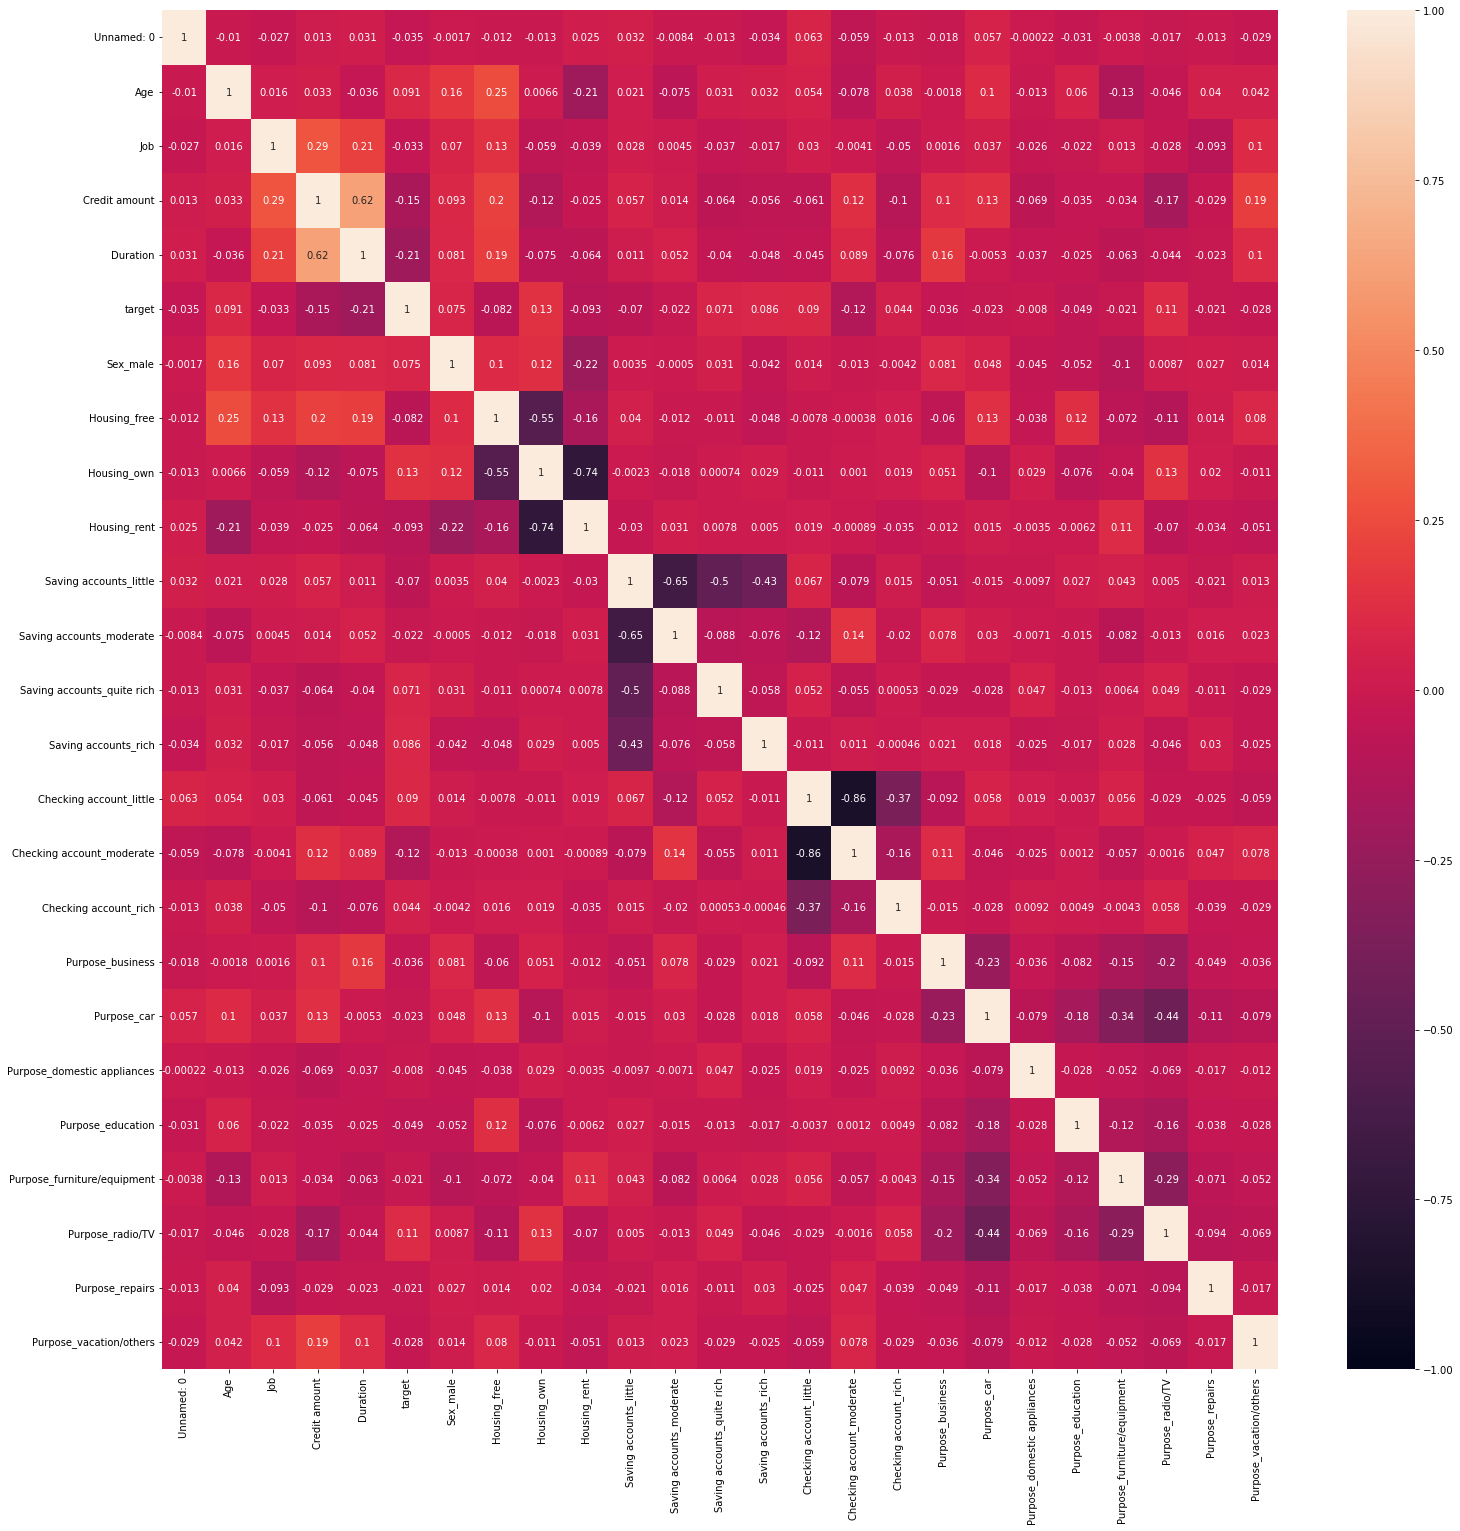

In [155]:
# plot correlation matrix
corrM = data.corr()
plt.figure(figsize = (25,25))
sns.heatmap(corrM, annot = True, cbar = True, vmin = -1, vmax= 1)

<AxesSubplot:>

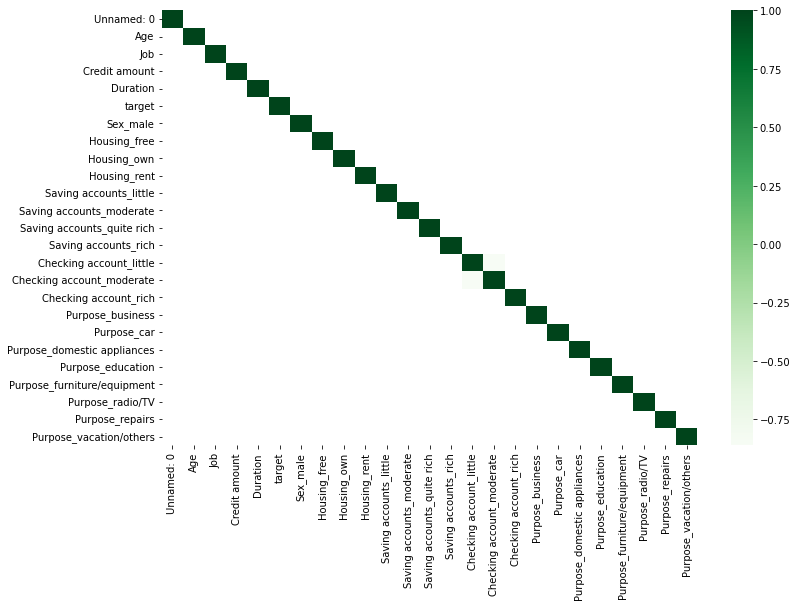

In [156]:
corr_features = corrM[(corrM >= 0.8) | (corrM <= -0.8)]
# corr_features
plt.figure(figsize=(12,8))
sns.heatmap(corr_features, cmap="Greens")

In [157]:
# get correleation of each features with the target
corrM['target'][:]

Unnamed: 0                    -0.034606
Age                            0.091127
Job                           -0.032735
Credit amount                 -0.154739
Duration                      -0.214927
target                         1.000000
Sex_male                       0.075493
Housing_free                  -0.081556
Housing_own                    0.134589
Housing_rent                  -0.092785
Saving accounts_little        -0.070234
Saving accounts_moderate      -0.022255
Saving accounts_quite rich     0.070954
Saving accounts_rich           0.085749
Checking account_little        0.089895
Checking account_moderate     -0.119581
Checking account_rich          0.044009
Purpose_business              -0.036129
Purpose_car                   -0.022621
Purpose_domestic appliances   -0.008016
Purpose_education             -0.049085
Purpose_furniture/equipment   -0.020971
Purpose_radio/TV               0.106922
Purpose_repairs               -0.020828
Purpose_vacation/others       -0.028058


(-1.0, 1.0)

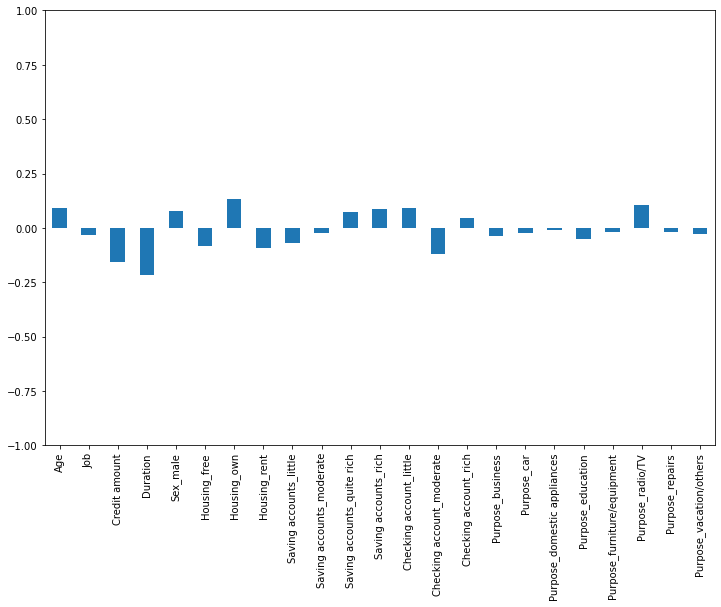

In [158]:
ax = corrM['target'][1:].drop('target').plot(kind='bar')
ax.set_ylim(-1.0,1.0)

In [175]:
# Separate target feature for training data
y_true = data["target"]
y_true.columns = ['target']
X = data.drop(columns = ["target"])
X.head()

,Unnamed: 0,Age,Job,Credit amount,Duration,Sex_male,Housing_free,Housing_own,Housing_rent,Saving accounts_little,...,Checking account_moderate,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,0,67,2,1169,6,1,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
1,1,22,2,5951,48,0,0,1,0,1,...,1,0,0,0,0,0,0,1,0,0
2,2,49,1,2096,12,1,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
3,3,45,2,7882,42,1,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,4,53,2,4870,24,1,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [176]:
y_true

0      1
1      0
2      1
3      1
4      0
      ..
995    1
996    1
997    1
998    0
999    1
Name: target, Length: 1000, dtype: int64

In [177]:
# Handle imbalanced data
smote = SMOTE()
X_sm, y_sm = smote.fit_resample(X, y_true)
X_sm

,Unnamed: 0,Age,Job,Credit amount,Duration,Sex_male,Housing_free,Housing_own,Housing_rent,Saving accounts_little,...,Checking account_moderate,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,0,67,2,1169,6,1,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
1,1,22,2,5951,48,0,0,1,0,1,...,1,0,0,0,0,0,0,1,0,0
2,2,49,1,2096,12,1,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
3,3,45,2,7882,42,1,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,4,53,2,4870,24,1,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,813,29,2,1204,19,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1396,806,45,3,14424,35,1,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
1397,973,28,0,1210,21,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
1398,447,26,1,1555,16,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


   labels  class_nums
0       1         700
1       0         700


<AxesSubplot:ylabel='class_nums'>

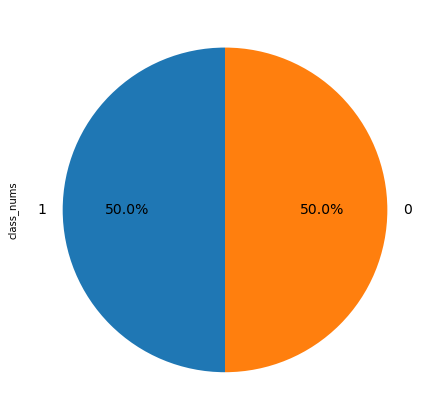

In [178]:
# Check if data is balanced
temp = y_sm.value_counts()
temp_data = pd.DataFrame({'labels': temp.index,
                   'class_nums': temp.values
                  })
print(temp_data)
plt.figure(figsize=(16,8))
ax1 = plt.subplot(121, aspect='equal')
temp_data.plot(kind='pie', y = 'class_nums', ax=ax1, autopct='%1.1f%%', 
 startangle=90, shadow=False, labels=temp_data['labels'], legend = False, fontsize=14)

In [179]:
# Run this to train with Un-balanced data
from sklearn.model_selection import train_test_split
# data splitting
X_train, X_test, y_train, y_test = train_test_split(
    X, y_true, random_state=42, test_size=0.3)

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (700, 24)
Shape of X_test:  (300, 24)
Shape of y_train:  (700,)
Shape of y_test:  (300,)


In [180]:
# Run this to train with Balanced data
from sklearn.model_selection import train_test_split
# data splitting
X_train, X_test, y_train, y_test = train_test_split(
    X_sm, y_sm, random_state=42, test_size=0.3)

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (980, 24)
Shape of X_test:  (420, 24)
Shape of y_train:  (980,)
Shape of y_test:  (420,)


# Training Different Models

In [181]:
clfs = [
    LogisticRegression(), 
    GaussianNB(),
    SVC(gamma='auto'),
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    XGBClassifier(), 
    AdaBoostClassifier()
    ]

scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

In [182]:
def train_models(X, y, models=clfs, splits_num=10, scoring=scoring):
    accs = []
    precisions = []
    recalls = []
    f1_scores = []
    n = []
    for clf in models:
        k_fold = KFold(n_splits=splits_num)
        sub_result = cross_validate(clf, X, y, cv=k_fold, scoring=scoring)
        clf_name = type(clf).__name__

        n.append(clf_name)
        accs.append(sub_result['test_accuracy'].mean())
        precisions.append(sub_result['test_precision'].mean())
        recalls.append(sub_result['test_recall'].mean())
        f1_scores.append(sub_result['test_f1_score'].mean())
    return accs, precisions, recalls, f1_scores, n



## Un-Balanced Dataset

In [165]:
accs, precisions, recalls, f1_scores, names= train_models(X,y)

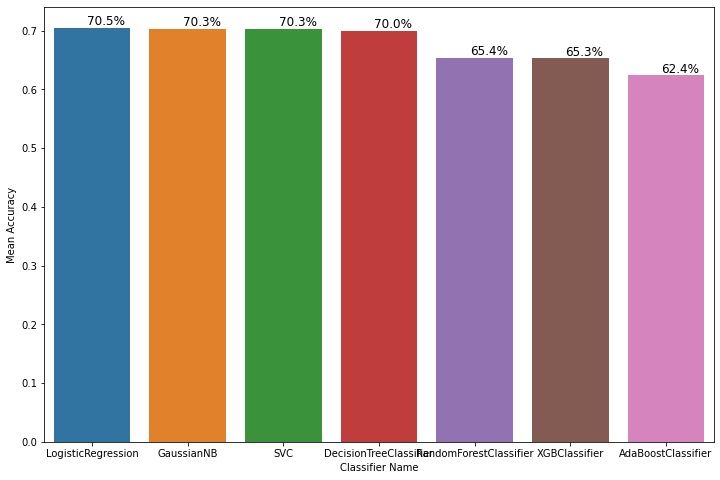

In [166]:
accs.sort(reverse=True)
temp_dict = {'x': names, 'y': accs}
ax = sns.barplot(x='x', y='y', data=temp_dict)

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height())
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height() + 0.005
    ax.annotate(percentage, (x, y), size = 12)
ax.set(xlabel='Classifier Name' , ylabel='Mean Accuracy')
plt.show()

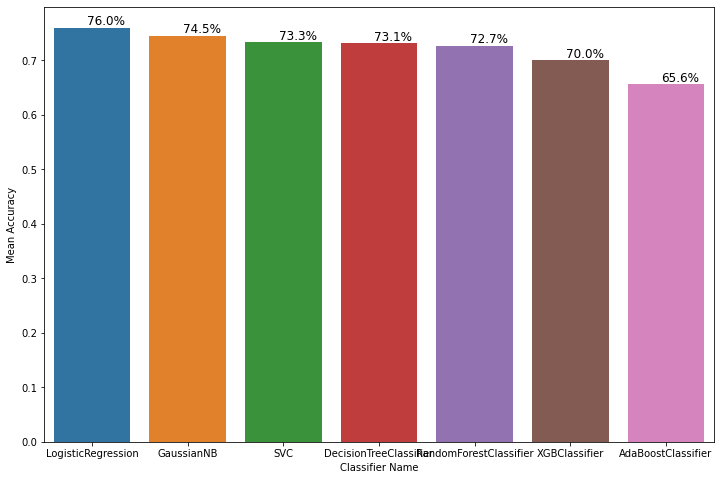

In [167]:
precisions.sort(reverse=True)
temp_dict = {'x': names, 'y': precisions}
ax = sns.barplot(x='x', y='y', data=temp_dict)

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height())
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height() + 0.005
    ax.annotate(percentage, (x, y), size = 12)
ax.set(xlabel='Classifier Name' , ylabel='Mean Accuracy')
plt.show()

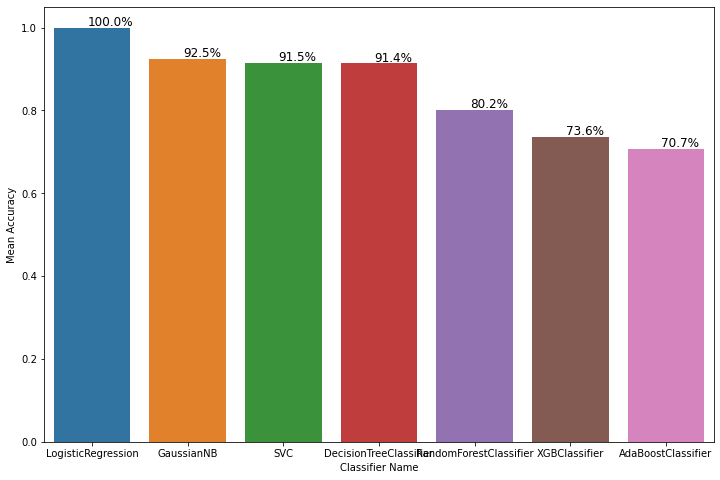

In [168]:
recalls.sort(reverse=True)
temp_dict = {'x': names, 'y': recalls}
ax = sns.barplot(x='x', y='y', data=temp_dict)

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height())
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height() + 0.005
    ax.annotate(percentage, (x, y), size = 12)
ax.set(xlabel='Classifier Name' , ylabel='Mean Accuracy')
plt.show()

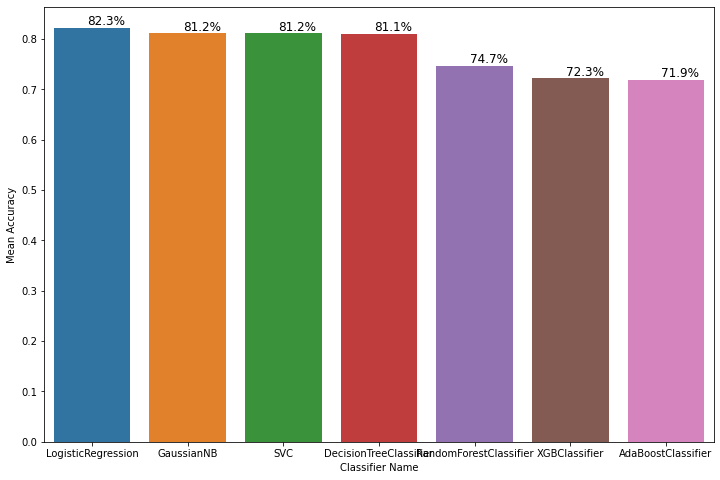

In [169]:
f1_scores.sort(reverse=True)
temp_dict = {'x': names, 'y': f1_scores}
ax = sns.barplot(x='x', y='y', data=temp_dict)

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height())
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height() + 0.005
    ax.annotate(percentage, (x, y), size = 12)
ax.set(xlabel='Classifier Name' , ylabel='Mean Accuracy')
plt.show()

## Balanced Data by SMOTE OverSamlpling

In [170]:
accs, precisions, recalls, f1_scores, names= train_models(X_sm, y_sm)

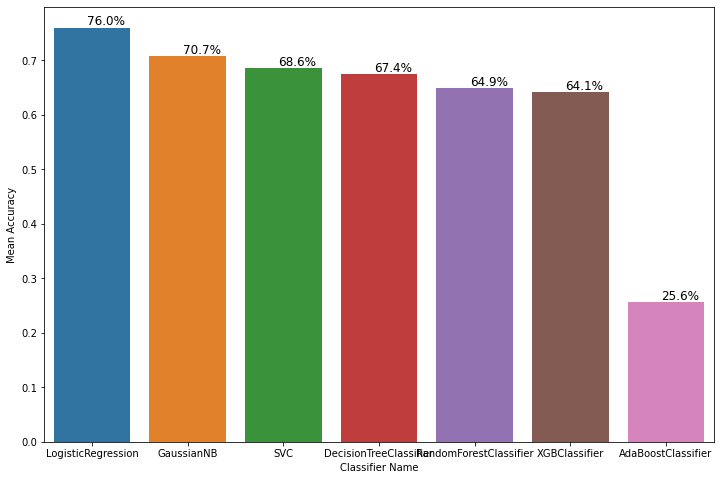

In [171]:
accs.sort(reverse=True)
temp_dict = {'x': names, 'y': accs}
ax = sns.barplot(x='x', y='y', data=temp_dict)

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height())
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height() + 0.005
    ax.annotate(percentage, (x, y), size = 12)
ax.set(xlabel='Classifier Name' , ylabel='Mean Accuracy')
plt.show()

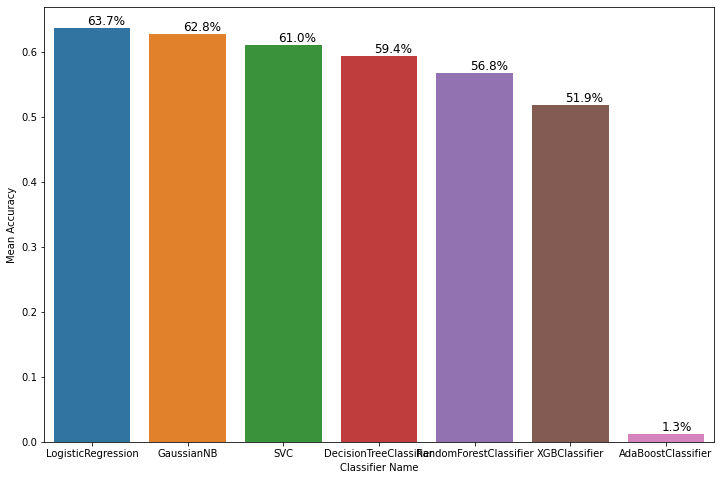

In [172]:
precisions.sort(reverse=True)
temp_dict = {'x': names, 'y': precisions}
ax = sns.barplot(x='x', y='y', data=temp_dict)

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height())
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height() + 0.005
    ax.annotate(percentage, (x, y), size = 12)
ax.set(xlabel='Classifier Name' , ylabel='Mean Accuracy')
plt.show()

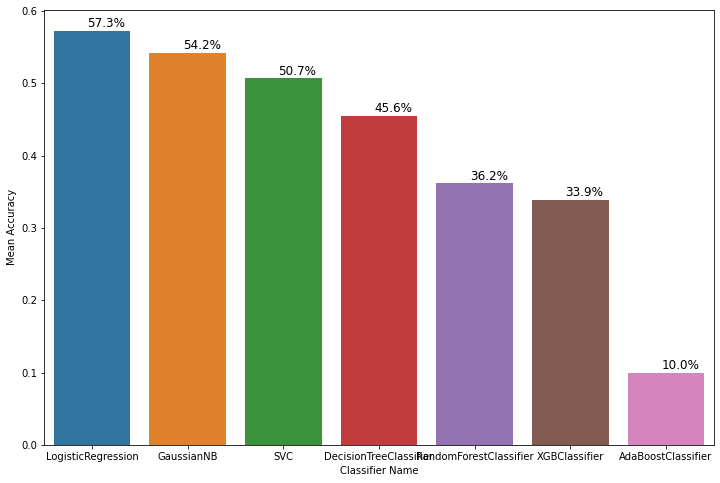

In [173]:
recalls.sort(reverse=True)
temp_dict = {'x': names, 'y': recalls}
ax = sns.barplot(x='x', y='y', data=temp_dict)

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height())
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height() + 0.005
    ax.annotate(percentage, (x, y), size = 12)
ax.set(xlabel='Classifier Name' , ylabel='Mean Accuracy')
plt.show()

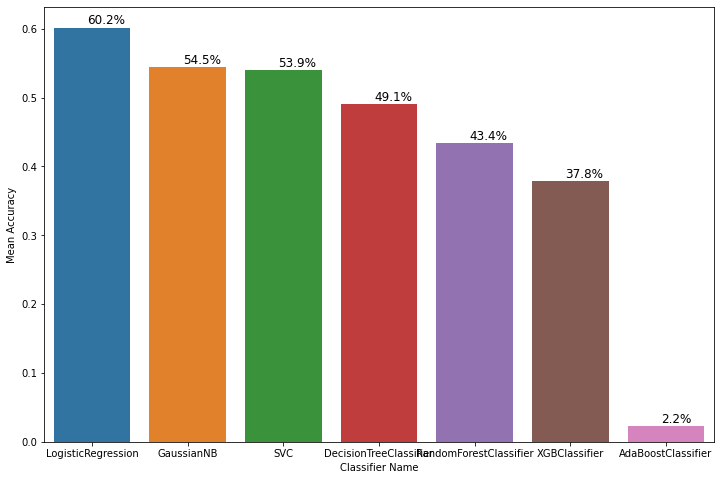

In [174]:
f1_scores.sort(reverse=True)
temp_dict = {'x': names, 'y': f1_scores}
ax = sns.barplot(x='x', y='y', data=temp_dict)

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height())
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height() + 0.005
    ax.annotate(percentage, (x, y), size = 12)
ax.set(xlabel='Classifier Name' , ylabel='Mean Accuracy')
plt.show()

# Hyperparameters Tuning

In [192]:
def tune_model(X, y_true, model, param_grid, k_folds, scoring):
    # define grid search  
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=k_folds, scoring=scoring)
    grid_result = grid_search.fit(X, y_true)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    return grid_result.best_estimator_

## LR

In [204]:
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)

best_lr_clf = tune_model(X, y_true, clfs[0], grid, 10, 'f1')

/Users/marwamostsafa/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/marwamostsafa/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

Best: 0.822629 using {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
0.815304 (0.021554) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.809742 (0.023208) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.812507 (0.022140) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.816543 (0.020438) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.811063 (0.019658) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.814790 (0.021710) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.818028 (0.021374) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.810462 (0.022665) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.816721 (0.021302) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.821353 (0.016538) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.814724 (0.023950) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.821833 (0.020325) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.820142 (0.012868) wi

/Users/marwamostsafa/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## GaussianNB

In [203]:
grid = dict(var_smoothing=[1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6])
best_nb_clf = tune_model(X, y_true, clfs[1], grid, 10, 'f1')

Best: 0.813743 using {'var_smoothing': 1e-07}
0.734590 (0.046901) with: {'var_smoothing': 1e-11}
0.735098 (0.046887) with: {'var_smoothing': 1e-10}
0.742735 (0.044336) with: {'var_smoothing': 1e-09}
0.794909 (0.029013) with: {'var_smoothing': 1e-08}
0.813743 (0.029343) with: {'var_smoothing': 1e-07}
0.812335 (0.033017) with: {'var_smoothing': 1e-06}


## SVC

In [205]:
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']

grid = dict(kernel=kernel,C=C,gamma=gamma)

best_svc = tune_model(X, y_true, clfs[2], grid, 10, 'f1')

Best: 0.827933 using {'C': 50, 'gamma': 'scale', 'kernel': 'poly'}
0.827933 (0.009406) with: {'C': 50, 'gamma': 'scale', 'kernel': 'poly'}
0.821322 (0.015067) with: {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
0.735447 (0.046300) with: {'C': 50, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.827933 (0.009406) with: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
0.823998 (0.014157) with: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.735871 (0.045882) with: {'C': 10, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.827156 (0.008539) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'poly'}
0.823706 (0.011782) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.735107 (0.046011) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.825256 (0.009521) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
0.822129 (0.004202) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.803531 (0.013905) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.824926 (0.006581) with: {'C': 0.01, 'gamma': 'scale',

## Decision Tree

In [208]:
criterion = ['gini', 'entropy']
max_depth = range(1, 10)
min_samples_split = range(1, 20, 2)
min_samples_leaf = range(1, 5)

grid = dict(criterion=criterion,max_depth=max_depth,min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
best_dt = tune_model(X, y_true, clfs[3], grid, 10, 'f1')

Best: 0.823529 using {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 3}
nan (nan) with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 1}
0.823529 (0.000000) with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 3}
0.823529 (0.000000) with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 5}
0.823529 (0.000000) with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 7}
0.823529 (0.000000) with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 9}
0.823529 (0.000000) with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 11}
0.823529 (0.000000) with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 13}
0.823529 (0.000000) with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 15}
0.823529 (0.0

## Random Forest

In [207]:
grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30,None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, ]}
 
best_rf = tune_model(X, y_true, clfs[4], grid, 10, 'f1')

Best: 0.827486 using {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
0.827486 (0.022534) with: {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
0.821099 (0.019635) with: {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
0.823689 (0.020799) with: {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 600}
0.818470 (0.021337) with: {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
0.821755 (0.018953) with: {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}
0.826376 (0.020025) with: {'bootstrap': True, 'max_depth': 10, 'max_feature

## XGBoost

In [216]:
grid = {
        'min_child_weight': [1, 5, 10],
        'learning_rate': [0.01, 0.1, 0.2, 0.3],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
best_xgb = tune_model(X, y_true, clfs[5], grid, 10, 'f1')

Best: 0.826729 using {'colsample_bytree': 0.8, 'gamma': 1.5, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.8}
0.822508 (0.008123) with: {'colsample_bytree': 0.6, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.6}
0.820805 (0.008573) with: {'colsample_bytree': 0.6, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8}
0.815750 (0.012362) with: {'colsample_bytree': 0.6, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0}
0.823468 (0.008719) with: {'colsample_bytree': 0.6, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.6}
0.823057 (0.010069) with: {'colsample_bytree': 0.6, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.8}
0.816010 (0.013657) with: {'colsample_bytree': 0.6, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 

In [217]:
# TODO Save the best model (SVC and RF are close but i will pick RF)
import pickle

# save the classifier
with open('/Credit-Risk-Assessment/Models/rf_classifier.pkl', 'wb') as fid:
    pickle.dump(best_rf, fid)    

In [219]:
# Load best model

with open('/Credit-Risk-Assessment/Models/rf_classifier.pkl', 'rb') as fid:
    best_clf = pickle.load(fid)